In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm
import numpy as np

import sys
import argparse
import neurokit2 as nk
import json
import scipy
from datetime import datetime

import random

In [4]:
# Initialize a variable with the current directory
directory = os.getcwd()

# Create a list to store the directory names
directories = [directory]

# Navigate up the directory tree and store names in the list
while True:
    directory, tail = os.path.split(directory)
    if not tail:
        break
    directories.append(directory)

# Get directories we want
current_directory = directories[0]
dev_directory = directories[2]

# Set the path to the database directory with hdf5 files
shared_dir = directories[-3]
database = 'Database - ECG'
db_directory = os.path.join(shared_dir, database)

# Set the path to the data directory destination (where to save the extracted files)
data_subdirectory = 'input\\ECG_db_new'
data_directory = os.path.join(dev_directory, data_subdirectory)

# Print the directories neatly
print("Current Directory:", current_directory)
print("Dev Directory:", dev_directory)
print("Database Directory", db_directory)
print("Destination Data Directory", data_directory)

Current Directory: x:\GDrive\Shared drives\Project - NeRF ILR to ECG\dev\notebooks\modeling\ConvexECG
Dev Directory: x:\GDrive\Shared drives\Project - NeRF ILR to ECG\dev\notebooks
Database Directory x:\GDrive\Shared drives\Database - ECG
Destination Data Directory x:\GDrive\Shared drives\Project - NeRF ILR to ECG\dev\notebooks\input\ECG_db_new


In [5]:
from __future__ import print_function

import numpy as np

import pyxis as px

from utils import compute_losses, plot_predictions_vs_ground_truth

In [6]:
import h5py

# Load the HDF5 file for a specific patient
patient_id = 'X1042'  # Replace with actual patient ID
mat_pth = r"X:\Dataset Files\MATLAB"
filename = f'Patient_{patient_id}_ECG_PPG.h5'
mat_file_path = os.path.join(mat_pth, filename)

# Open the HDF5 file and load ECG and PPG data
with h5py.File(mat_file_path, 'r') as f:
    ecg_data = f['/ECG'][:]
    ppg_data = f['/PPG'][:]

# Inspect the data
print(f"ECG Data Shape: {ecg_data.shape}")
print(f"PPG Data Shape: {ppg_data.shape}")


ECG Data Shape: (1, 417000)
PPG Data Shape: (1, 417000)


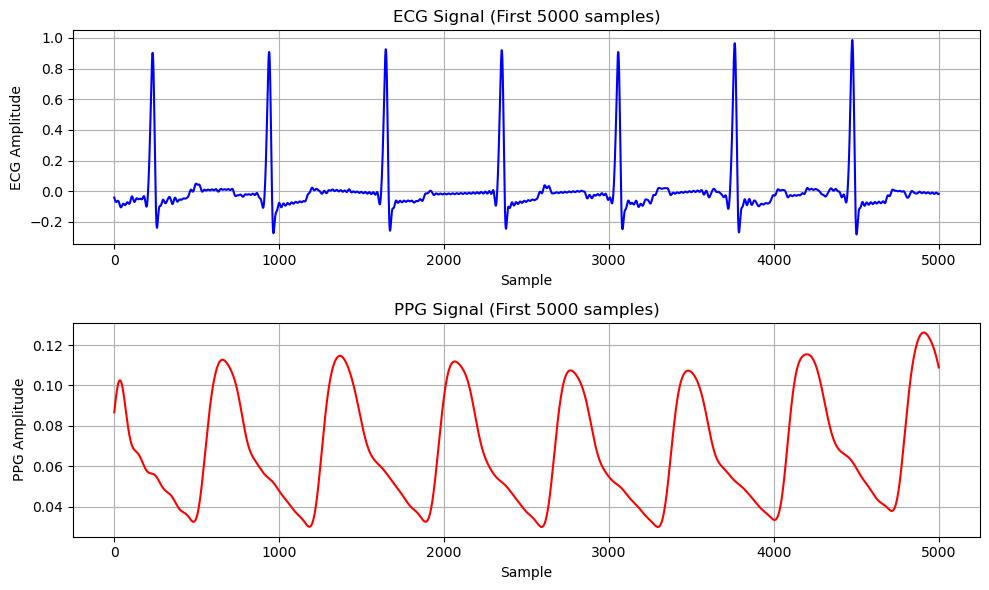

In [7]:
import matplotlib.pyplot as plt

ecg_data_snippet = ecg_data[0][:5000]  # First 1000 samples of ECG
ppg_data_snippet = ppg_data[0][:5000]  # First 1000 samples of PPG
time = range(5000)

plt.figure(figsize=(10, 6))

# Subplot for ECG
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st plot
plt.plot(time, ecg_data_snippet, label='ECG', color='b')
plt.title('ECG Signal (First 5000 samples)')
plt.ylabel('ECG Amplitude')
plt.xlabel('Sample')
plt.grid(True)

# Subplot for PPG
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd plot
plt.plot(time, ppg_data_snippet, label='PPG', color='r')
plt.title('PPG Signal (First 5000 samples)')
plt.ylabel('PPG Amplitude')
plt.xlabel('Sample')
plt.grid(True)

# Show the plots
plt.tight_layout()  # Adjust layout so titles/labels don't overlap
plt.show()

In [8]:
ppg_data_snippet.shape

(5000,)

In [9]:
import numpy as np

def z_score_normalize(signal):
    """
    Z-score normalize a 1D signal.
    
    Args:
        signal (numpy array): Input signal to be normalized.
        
    Returns:
        numpy array: Z-score normalized signal.
    """
    mean = np.mean(signal)
    std = np.std(signal)
    
    # Z-score normalization
    z_normalized_signal = (signal - mean) / std
    
    return z_normalized_signal

# Function to print number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [10]:
ppg_data_down = z_score_normalize(ppg_data[0][::8])
ecg_data_down = z_score_normalize(ecg_data[0][::8])

print(ppg_data_down.shape)
print(ecg_data_down.shape)

(52125,)
(52125,)


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split

# Define the segment size (e.g., 100 time steps)
segment_size = 75

# Function to segment data
def create_segments(data, segment_size):
    return np.array([data[i:i+segment_size] for i in range(0, len(data) - segment_size + 1, segment_size)])

# Use first 5000 samples for training and testing
X = ppg_data_down[:5000]
y = ecg_data_down[:5000]

# Create segments for training and testing
X_train = create_segments(X, segment_size)
y_train = create_segments(y, segment_size)

# Now create validation set using samples from 5000 to 6000
X_val_data = ppg_data_down[5000:6000]
y_val_data = ecg_data_down[5000:6000]

X_val = create_segments(X_val_data, segment_size)
y_val = create_segments(y_val_data, segment_size)

# If you want an additional test set (6000:7000), you can create it as follows:
X_test_data = ppg_data_down[10000:11000]
y_test_data = ecg_data_down[10000:11000]

X_test = create_segments(X_test_data, segment_size)
y_test = create_segments(y_test_data, segment_size)

# Print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (66, 75)
y_train shape: (66, 75)
X_val shape: (13, 75)
y_val shape: (13, 75)
X_test shape: (13, 75)
y_test shape: (13, 75)


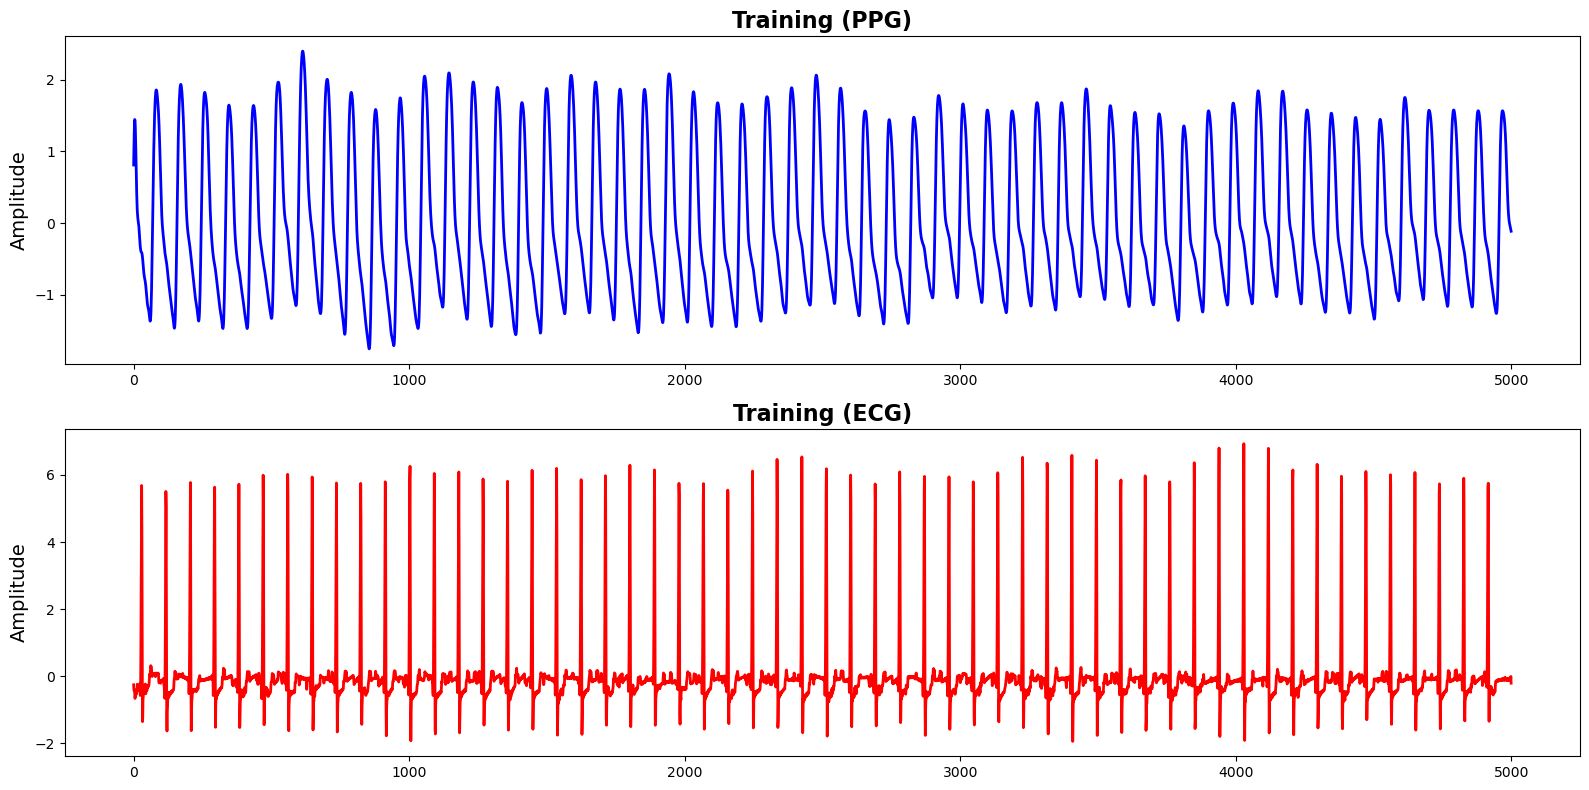

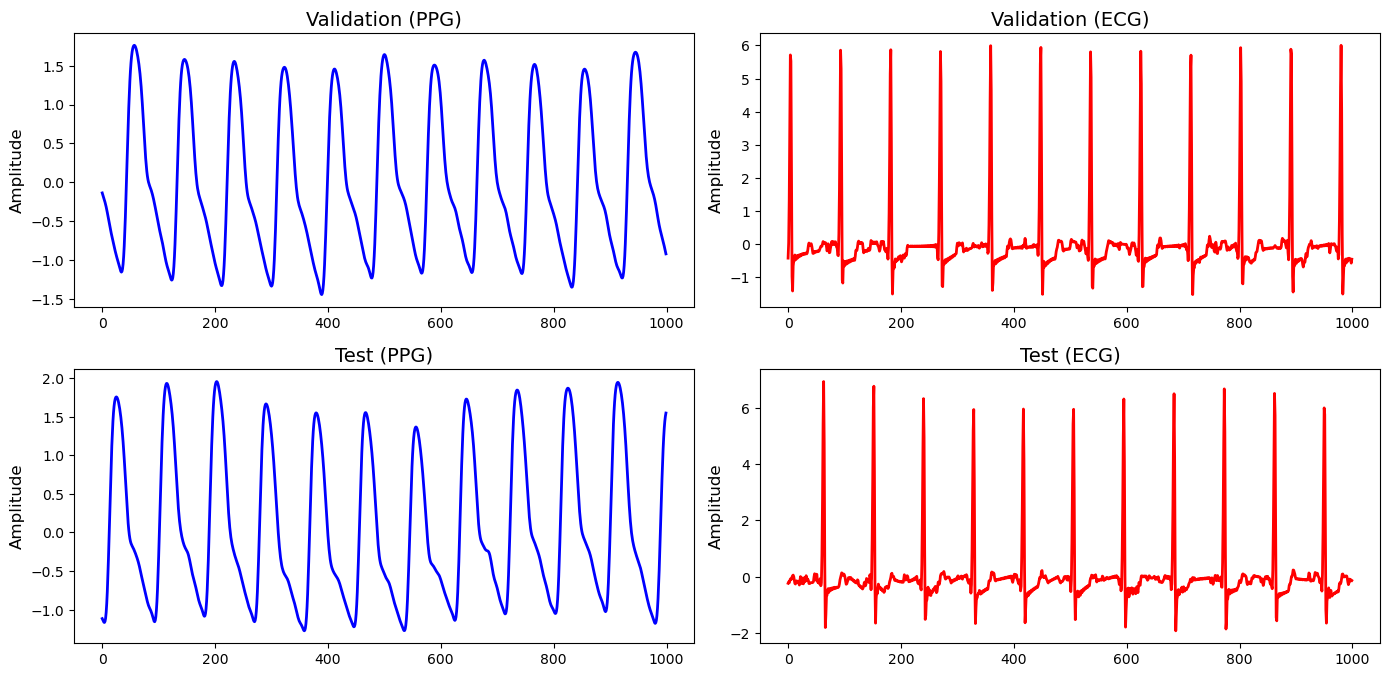

In [12]:
import matplotlib.pyplot as plt

# Function to plot PPG and ECG data with improved style
def plot_signals(ppg_data, ecg_data, title_ppg, title_ecg, signal_type, fig_size=(12, 12), plot_type='small'):
    # For larger plots (Training)
    if plot_type == 'large':
        plt.figure(figsize=fig_size)
        plt.subplot(2, 1, 1)
        plt.plot(ppg_data, color='blue', linewidth=2)
        plt.title(f'{title_ppg} (PPG)', fontsize=16, fontweight='bold')
        plt.ylabel('Amplitude', fontsize=14)
        plt.grid(False)

        plt.subplot(2, 1, 2)
        plt.plot(ecg_data, color='red', linewidth=2)
        plt.title(f'{title_ecg} (ECG)', fontsize=16, fontweight='bold')
        plt.ylabel('Amplitude', fontsize=14)
        plt.tight_layout()
        plt.show()
    # For smaller plots (Validation/Test)
    else:
        plt.subplot(3, 2, signal_type)
        plt.plot(ppg_data, color='blue', linewidth=2)
        plt.title(f'{title_ppg} (PPG)', fontsize=14)
        plt.ylabel('Amplitude', fontsize=12)
        plt.grid(False)

        plt.subplot(3, 2, signal_type + 1)
        plt.plot(ecg_data, color='red', linewidth=2)
        plt.title(f'{title_ecg} (ECG)', fontsize=14)
        plt.ylabel('Amplitude', fontsize=12)
        plt.grid(False)

# Plot the Training data in a larger plot
plot_signals(X, y, 'Training', 'Training', 1, fig_size=(16, 8), plot_type='large')

# Plot Validation and Test data in smaller plots
plt.figure(figsize=(14, 10))

# Plot Validation data
plot_signals(X_val_data, y_val_data, 'Validation', 'Validation', 1, plot_type='small')

# Plot Test data
plot_signals(X_test_data, y_test_data, 'Test', 'Test', 3, plot_type='small')

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()


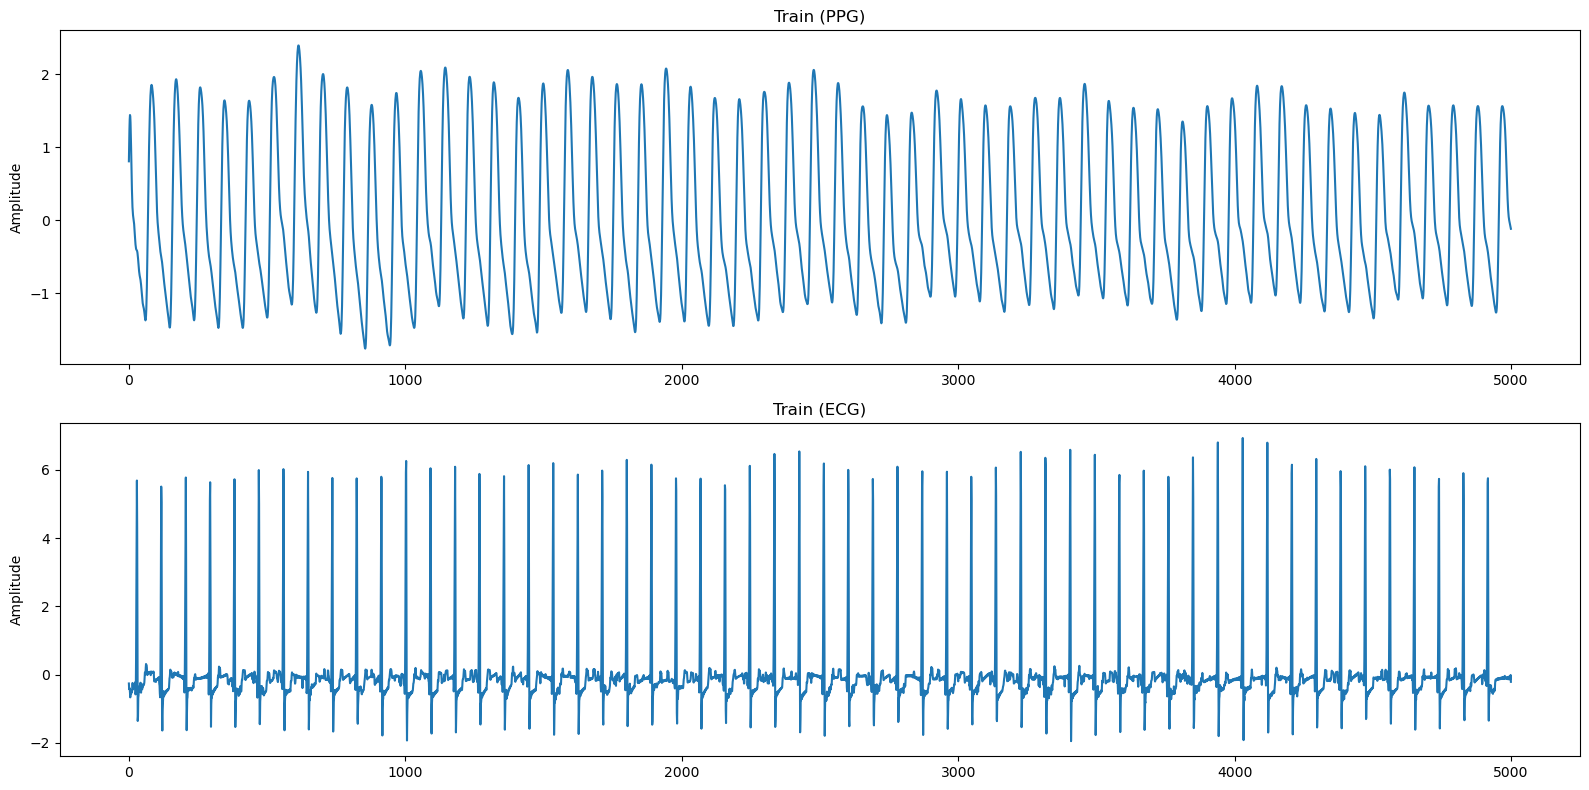

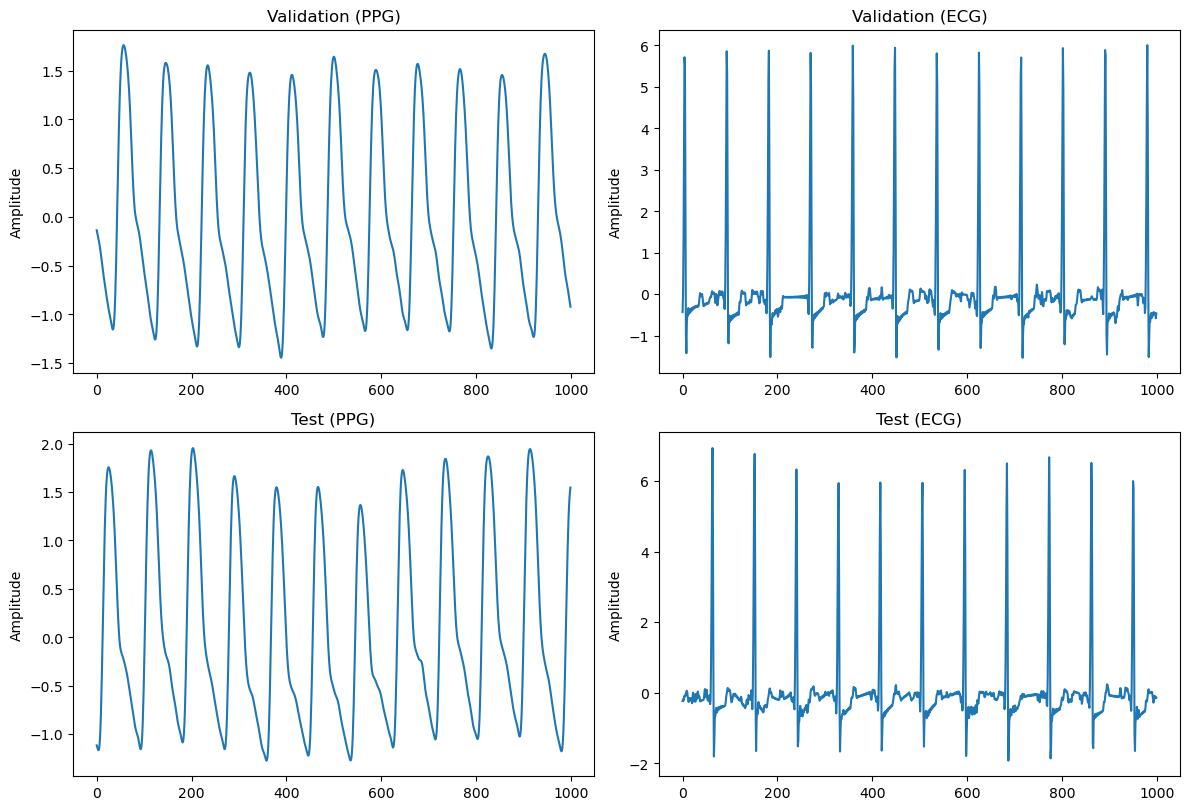

In [13]:
import matplotlib.pyplot as plt

# Function to plot PPG and ECG data
def plot_signals(ppg_data, ecg_data, title_ppg, title_ecg, signal_type, fig_size=(12, 12), plot_type='small'):
    # For larger plots (Training)
    if plot_type == 'large':
        plt.figure(figsize=fig_size)
        plt.subplot(2, 1, 1)
        plt.plot(ppg_data)
        plt.title(f'{title_ppg} (PPG)')
        plt.ylabel('Amplitude')

        plt.subplot(2, 1, 2)
        plt.plot(ecg_data)
        plt.title(f'{title_ecg} (ECG)')
        plt.ylabel('Amplitude')
        plt.tight_layout()
        plt.show()
    # For smaller plots (Validation/Test)
    else:
        plt.subplot(3, 2, signal_type)
        plt.plot(ppg_data)
        plt.title(f'{title_ppg} (PPG)')
        plt.ylabel('Amplitude')
        
        plt.subplot(3, 2, signal_type + 1)
        plt.plot(ecg_data)
        plt.title(f'{title_ecg} (ECG)')
        plt.ylabel('Amplitude')

# Plot the Training data in a larger plot
plot_signals(X, y, 'Train', 'Train', 1, fig_size=(16, 8), plot_type='large')

# Plot Validation and Test data in smaller plots
plt.figure(figsize=(12, 12))

# Plot Validation data
plot_signals(X_val_data, y_val_data, 'Validation', 'Validation', 1, plot_type='small')

# Plot Test data
plot_signals(X_test_data, y_test_data, 'Test', 'Test', 3, plot_type='small')

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()


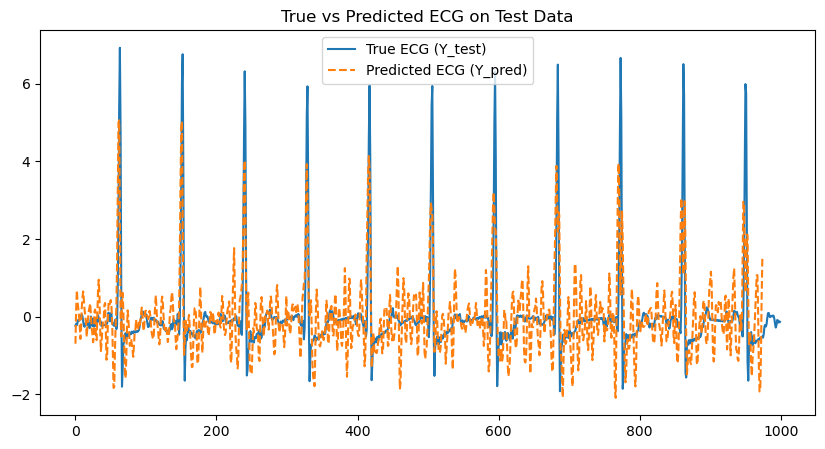

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Linear regression model
model = LinearRegression()

# Train the model on X_train and Y_train
model.fit(X_train, y_train)

# Predict Y_test from X_test
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()


# Plot actual vs predicted
plt.figure(figsize=(10, 5))

plt.plot(y_test_data, label='True ECG (Y_test)')
plt.plot(y_pred, label='Predicted ECG (Y_pred)', linestyle='dashed')
plt.title('True vs Predicted ECG on Test Data')
plt.legend()
plt.show()


In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_vs_ground_truth(dataset, predictions):
    """
    Plot predictions and ground truth for each target lead in separate subplots.
    
    Parameters:
    - dataset: The dataset object containing the ground truth (Y_test).
    - predictions: The predicted values with shape (number of targets, length, 1).
    """
    num_leads = predictions.shape[0]  # Number of target leads
    
    # Create subplots, ensuring axs is always a 2D array
    fig, axs = plt.subplots(num_leads, 1, figsize=(10, 5 * num_leads), squeeze=False)

    for i in range(num_leads):
        # Plot ground truth
        axs[i, 0].plot(dataset.Y_test[i].squeeze(), label=f'Ground Truth (Lead {i})', color='blue')
        
        # Plot predictions
        axs[i, 0].plot(predictions[i].squeeze(), label=f'Predicted (Lead {i})', color='orange', linestyle='--')
        
        # Set titles and legends
        axs[i, 0].set_title(f'Lead {i} - Predictions vs Ground Truth')
        axs[i, 0].legend()
        axs[i, 0].set_xlabel('Time (samples)')
        axs[i, 0].set_ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch


from scnn.private.utils.data import gen_classification_data
from scnn.optimize import optimize
from scnn.regularizers import NeuronGL1, L2, L1

# number of activation patterns to use.
max_neurons = 300

lam = 0.000065

cvx_model, metrics = optimize("gated_relu", 
                          max_neurons,
                          X_train, 
                          y_train, 
                          X_test, 
                          y_test, 
                          regularizer=L1(lam),
                          verbose=True,  
                          device="cpu")


print(f"Hidden Layer Size: {cvx_model.parameters[0].shape[0]}")
pred = cvx_model(X_test)
pred.shape

INFO:scnn:Pre-Optimization Metrics: Train Set objective: 0.5490647687815656, Train Set grad_norm: 0.049613241106271744, 


fista:   0%|          | 0/10000 [00:00<?, ?it/s]

Train Set objective: 0.5490647687815656, Train Set grad_norm: 0.049613241106271744, 
Train Set objective: 0.260690608859592, Train Set grad_norm: 0.000325199420331046, 
Train Set objective: 0.23088795050110478, Train Set grad_norm: 5.468571998790139e-06, 
Train Set objective: 0.22309690432153564, Train Set grad_norm: 4.307103154133074e-06, 


INFO:scnn:Termination criterion satisfied at iteration 91/10000. Exiting optimization loop.
INFO:scnn:Post-Optimization Metrics: Train Set objective: 0.2194566485040838, Train Set grad_norm: 9.957087740986026e-07, 


Hidden Layer Size: 2993


(13, 75)

In [17]:
import numpy as np

def count_non_zero_parameters(cvx_model):
    non_zero_params = 0
    for param in cvx_model.parameters:
        non_zero_params += np.count_nonzero(param)
    return non_zero_params

print(f"Hidden Layer 1 Shape: {cvx_model.parameters[0].shape}")
print(f"Hidden Layer 2 Shape: {cvx_model.parameters[1].shape}")
print(f"Number of non-zero parameters in the convex model: {count_non_zero_parameters(cvx_model)}")


Hidden Layer 1 Shape: (2993, 75)
Hidden Layer 2 Shape: (75, 2993)
Number of non-zero parameters in the convex model: 39316


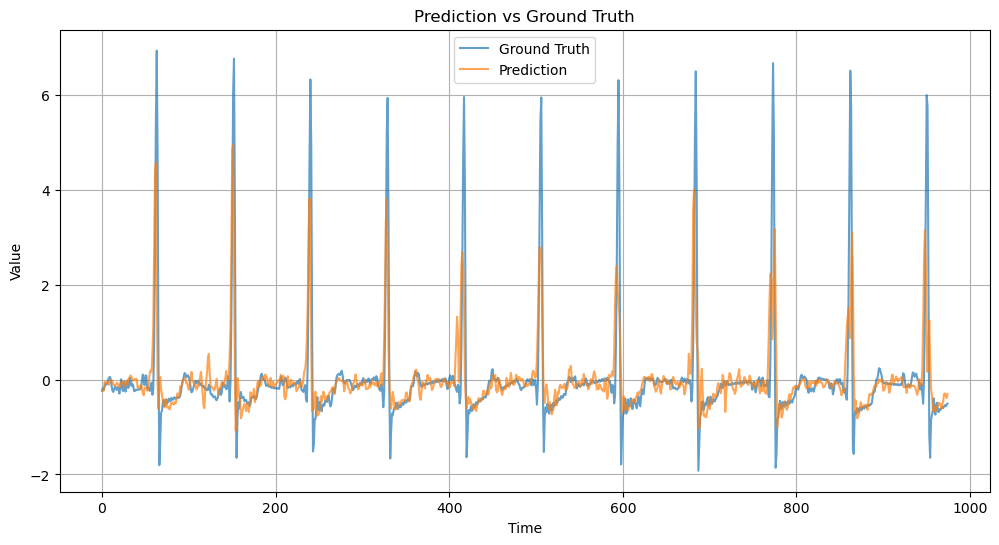

Mean Squared Error: 0.6431992871247921


In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Concatenate the segments to reconstruct the full sequence
y_test_full = y_test.flatten()
pred_full = pred.flatten() # Assuming pred is a PyTorch tensor

# Create a time axis
time = np.arange(len(y_test_full))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(time, y_test_full, label='Ground Truth', alpha=0.7)
plt.plot(time, pred_full, label='Prediction', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Prediction vs Ground Truth')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print Mean Squared Error
mse = np.mean((y_test_full - pred_full)**2)
print(f"Mean Squared Error: {mse}")

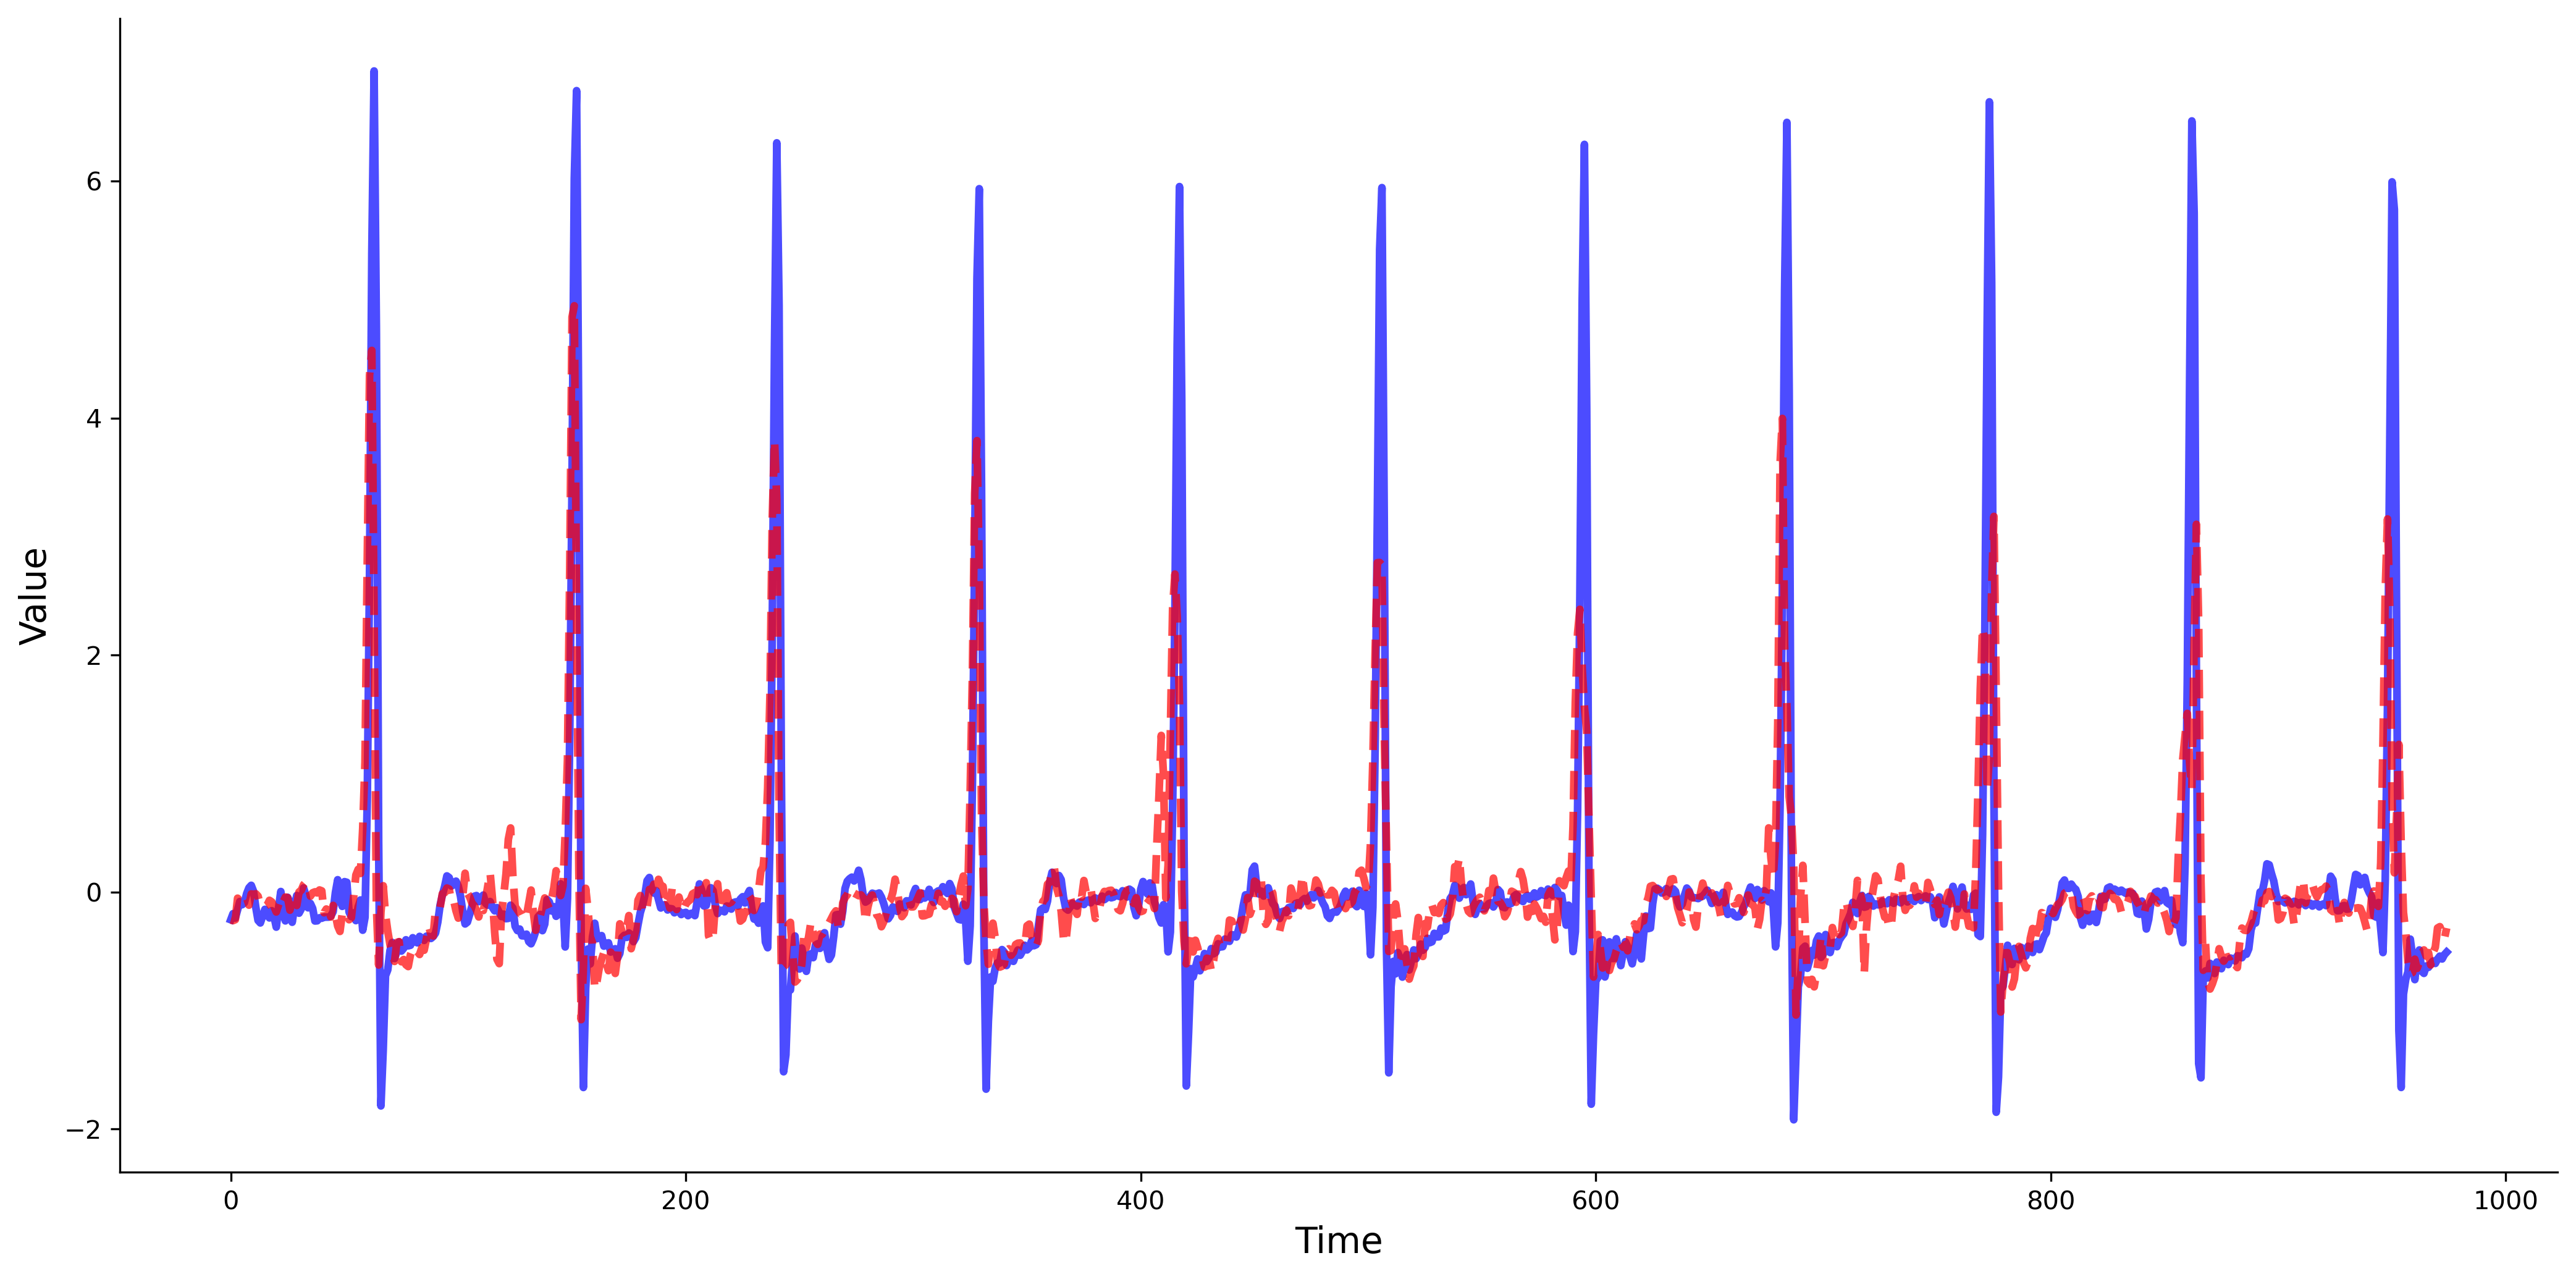

0.6431992871247921

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Create a time axis
time = np.arange(len(y_test_full))

# Plot
plt.figure(figsize=(14, 7), dpi=300)
plt.plot(time, y_test_full, color='blue', linewidth=3, alpha=0.7)
plt.plot(time, pred_full, color='red', linestyle='--', linewidth=3, alpha=0.7)

# Remove background and grid
plt.gca().set_facecolor('none')
plt.grid(False)

# Remove title and legend, keep axes
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)

# Remove spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()

# Calculate and print Mean Squared Error
mse = np.mean((y_test_full - pred_full)**2)
mse


In [20]:
import numpy as np

# Assuming y_test_full and pred_full are already defined and are numpy arrays of shape (1000,)

# Calculate the correlation
correlation = np.corrcoef(y_test_full, pred_full)[0, 1]

print(f"The correlation between y_test_full and pred_full is: {correlation:.4f}")

# Optional: Calculate and print the p-value
from scipy import stats

correlation_coefficient, p_value = stats.pearsonr(y_test_full, pred_full)
print(f"The p-value for this correlation is: {p_value:.4e}")

The correlation between y_test_full and pred_full is: 0.6780
The p-value for this correlation is: 3.1736e-132


Using device: cuda
Epoch [10/500], Train Loss: 0.8547, Val Loss: 0.9553
Epoch [20/500], Train Loss: 0.6927, Val Loss: 0.9290
Epoch [30/500], Train Loss: 0.5948, Val Loss: 0.8956
Epoch [40/500], Train Loss: 0.5207, Val Loss: 0.8549
Epoch [50/500], Train Loss: 0.4612, Val Loss: 0.8266
Epoch [60/500], Train Loss: 0.4056, Val Loss: 0.8163
Epoch [70/500], Train Loss: 0.3706, Val Loss: 0.7962
Epoch [80/500], Train Loss: 0.3405, Val Loss: 0.7627
Epoch [90/500], Train Loss: 0.3064, Val Loss: 0.7111
Epoch [100/500], Train Loss: 0.2885, Val Loss: 0.6844
Epoch [110/500], Train Loss: 0.2631, Val Loss: 0.6842
Epoch [120/500], Train Loss: 0.2425, Val Loss: 0.6495
Epoch [130/500], Train Loss: 0.2232, Val Loss: 0.6503
Epoch [140/500], Train Loss: 0.2105, Val Loss: 0.6217
Epoch [150/500], Train Loss: 0.1973, Val Loss: 0.6177
Epoch [160/500], Train Loss: 0.1905, Val Loss: 0.6052
Epoch [170/500], Train Loss: 0.1722, Val Loss: 0.5969
Epoch [180/500], Train Loss: 0.1682, Val Loss: 0.5875
Epoch [190/500], T

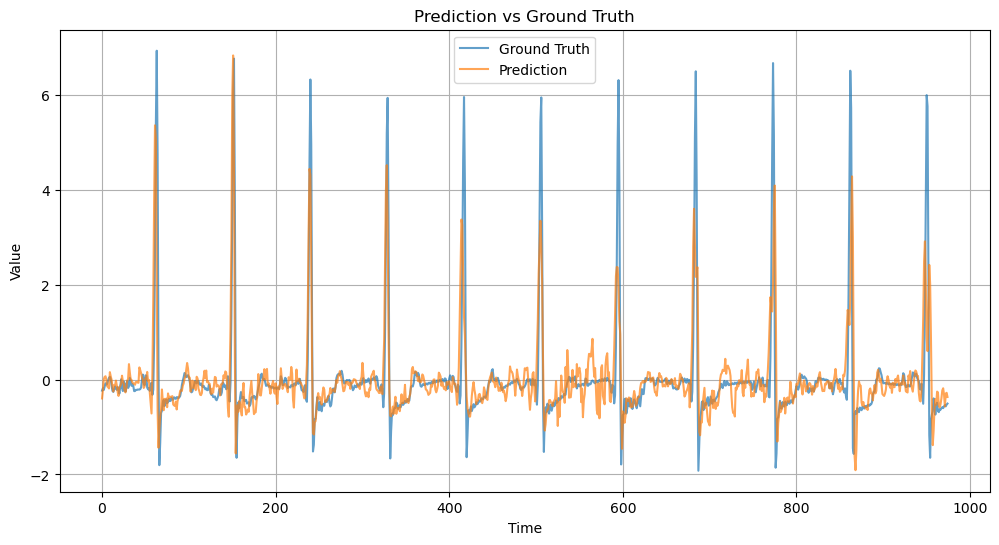

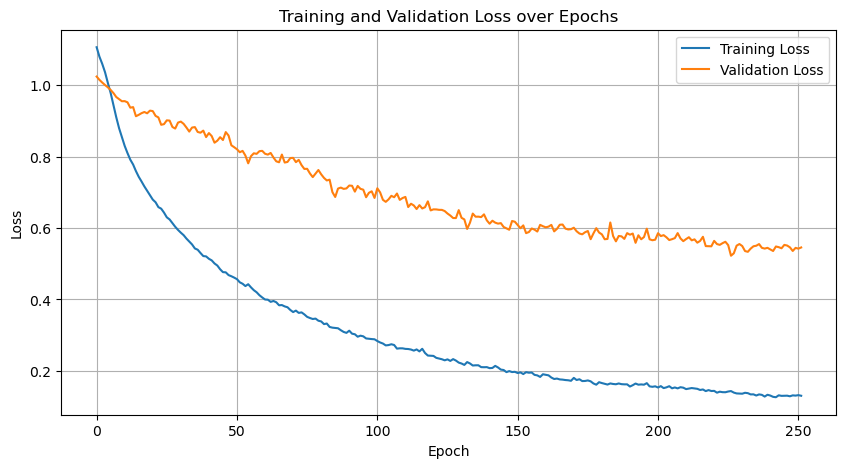

Mean Squared Error on test set: 0.6008063502714234


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Create DataLoader for training and validation data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size=segment_size, hidden_size=64, output_size=segment_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = MLP().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Early stopping parameters
patience = 25
best_val_loss = float('inf')
early_stopping_counter = 0

# Lists to store losses for plotting
train_losses = []
val_losses = []

num_epochs = 500
early_stop = True
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)  # Multiply by batch size for correct average
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0  # Reset counter if validation loss improves
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience and early_stop:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    # Logging at every 10th epoch
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Generate predictions on test data
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).cpu().numpy()

# Concatenate the segments to reconstruct the full sequence
y_test_full = y_test.flatten()
pred_full = predictions.flatten()

print(f"Number of parameters: {count_parameters(model)}")

# Create a time axis
time = np.arange(len(y_test_full))

# Plot the predictions vs ground truth
plt.figure(figsize=(12, 6))
plt.plot(time, y_test_full, label='Ground Truth', alpha=0.7)
plt.plot(time, pred_full, label='Prediction', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Prediction vs Ground Truth')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print Mean Squared Error on the test set
mse = np.mean((y_test_full - pred_full)**2)
print(f"Mean Squared Error on test set: {mse}")

Using device: cuda
Epoch [10/500], Train Loss: 1.0113, Val Loss: 0.9059
Epoch [20/500], Train Loss: 0.9822, Val Loss: 0.8661
Epoch [30/500], Train Loss: 0.9657, Val Loss: 0.8387
Epoch [40/500], Train Loss: 0.9595, Val Loss: 0.8311
Epoch [50/500], Train Loss: 0.9556, Val Loss: 0.8245
Epoch [60/500], Train Loss: 0.9516, Val Loss: 0.8183
Epoch [70/500], Train Loss: 0.9493, Val Loss: 0.8242
Epoch [80/500], Train Loss: 0.9462, Val Loss: 0.8174
Epoch [90/500], Train Loss: 0.9425, Val Loss: 0.8128
Epoch [100/500], Train Loss: 0.9394, Val Loss: 0.8120
Early stopping at epoch 104
Number of parameters: 1729


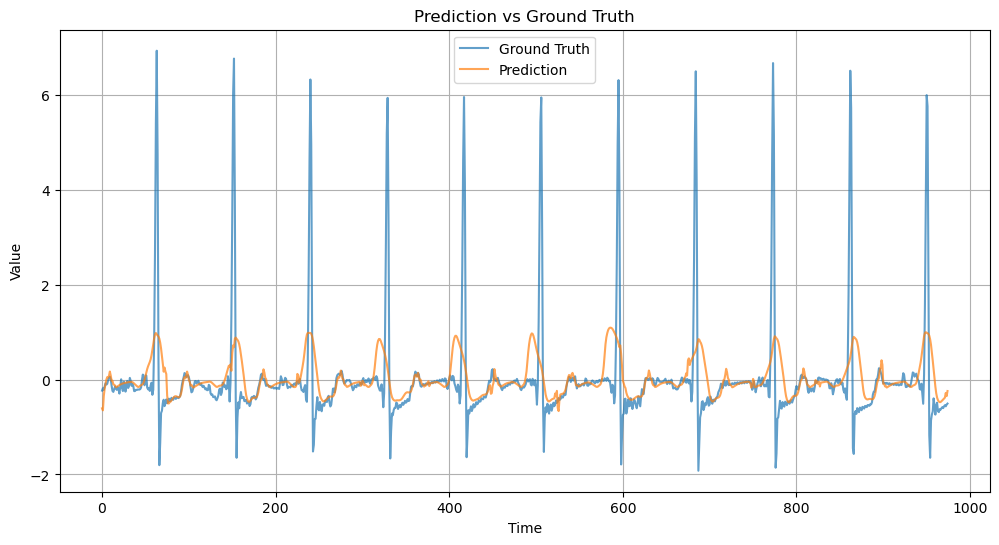

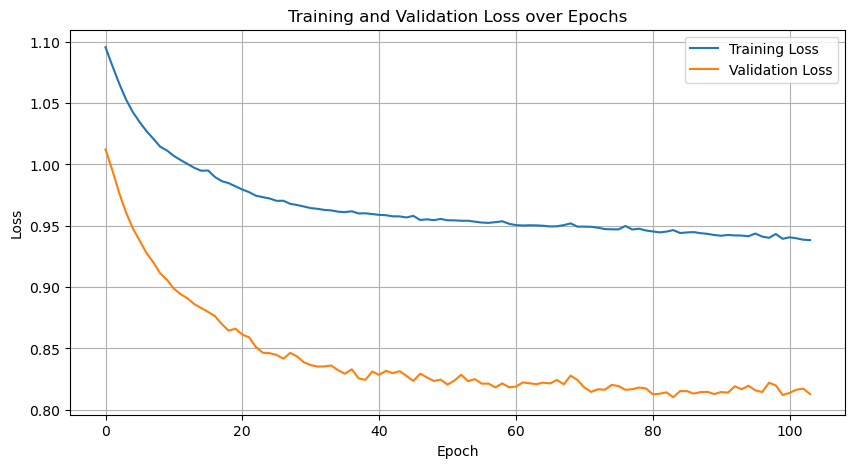

Mean Squared Error on test set: 1.0360385002218253


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).unsqueeze(1).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(1).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Create DataLoader for training and validation data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Define the 1D CNN model
class SimpleCNN1D(nn.Module):
    def __init__(self):
        super(SimpleCNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(32, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x.squeeze(1)

# Initialize the model, loss function, and optimizer
model = SimpleCNN1D().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Early stopping parameters
patience = 20
best_val_loss = float('inf')
early_stopping_counter = 0

# Lists to store losses for plotting
train_losses = []
val_losses = []

num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)  # Multiply by batch size for correct average
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0  # Reset counter if validation loss improves
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    # Logging at every 10th epoch
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Generate predictions on test data
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).cpu().numpy()

# Concatenate the segments to reconstruct the full sequence
y_test_full = y_test.flatten()
pred_full = predictions.flatten()  # Assuming pred is a PyTorch tensor

print(f"Number of parameters: {count_parameters(model)}")

# Create a time axis
time = np.arange(len(y_test_full))

# Plot the predictions vs ground truth
plt.figure(figsize=(12, 6))
plt.plot(time, y_test_full, label='Ground Truth', alpha=0.7)
plt.plot(time, pred_full, label='Prediction', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Prediction vs Ground Truth')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print Mean Squared Error on the test set
mse = np.mean((y_test_full - pred_full)**2)
print(f"Mean Squared Error on test set: {mse}")


Using device: cuda
Epoch [10/500], Train Loss: 0.9109, Val Loss: 0.7523
Epoch [20/500], Train Loss: 0.6612, Val Loss: 0.5651
Epoch [30/500], Train Loss: 0.5706, Val Loss: 0.5756
Epoch [40/500], Train Loss: 0.5044, Val Loss: 0.5070
Epoch [50/500], Train Loss: 0.4187, Val Loss: 0.4306
Epoch [60/500], Train Loss: 0.3945, Val Loss: 0.6157
Epoch [70/500], Train Loss: 0.4841, Val Loss: 0.8392
Epoch [80/500], Train Loss: 0.3202, Val Loss: 0.2774
Epoch [90/500], Train Loss: 0.4036, Val Loss: 0.4824
Epoch [100/500], Train Loss: 0.2477, Val Loss: 0.2966
Epoch [110/500], Train Loss: 0.2172, Val Loss: 0.2398
Epoch [120/500], Train Loss: 0.2179, Val Loss: 0.2336
Epoch [130/500], Train Loss: 0.2444, Val Loss: 0.3946
Epoch [140/500], Train Loss: 0.2392, Val Loss: 0.2682
Epoch [150/500], Train Loss: 0.1709, Val Loss: 0.2045
Epoch [160/500], Train Loss: 0.1623, Val Loss: 0.2161
Epoch [170/500], Train Loss: 0.1807, Val Loss: 0.3242
Epoch [180/500], Train Loss: 0.1860, Val Loss: 0.2718
Epoch [190/500], T

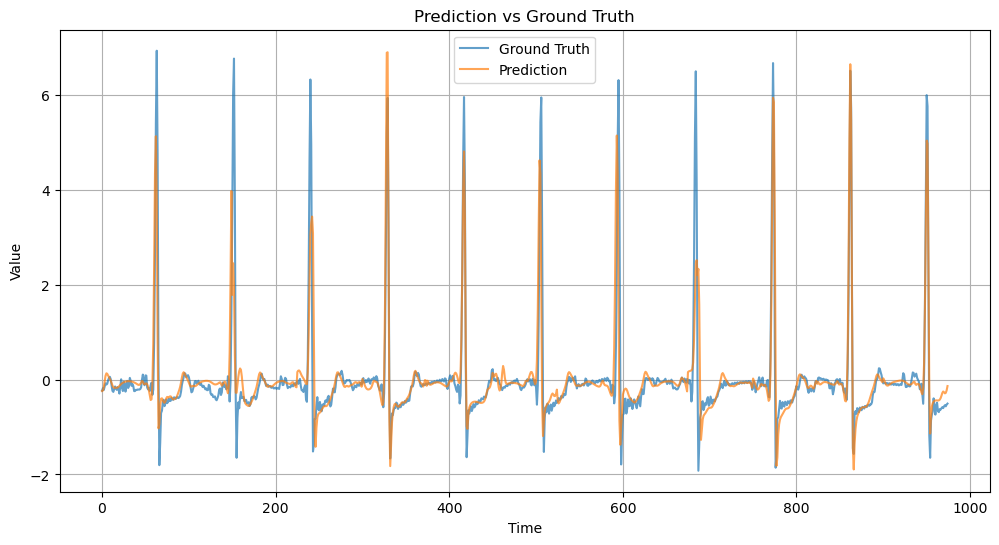

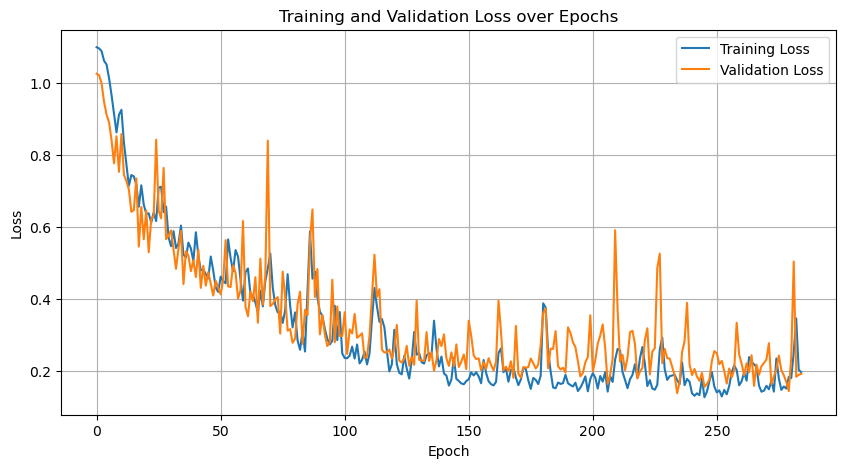

Mean Squared Error on test set: 0.3885847007625006


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Create DataLoader for training and validation data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Define the BiLSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)  # Output a single value for each time step

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out.squeeze(-1)  # Remove the last dimension to match target shape

# Initialize the model, loss function, and optimizer
model = BiLSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Early stopping parameters
patience = 50
best_val_loss = float('inf')
early_stopping_counter = 0

# Lists to store losses for plotting
train_losses = []
val_losses = []

# Training loop with early stopping
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X.unsqueeze(2))  # Add channel dimension
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X.unsqueeze(2))
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0  # Reset counter if validation loss improves
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    # Logging at every 10th epoch
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Generate predictions on test data
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor.unsqueeze(2)).cpu().numpy()

print(f"Number of parameters: {count_parameters(model)}")

# Concatenate the segments to reconstruct the full sequence
y_test_full = y_test.flatten()
pred_full = predictions.flatten()
X_test_full = X_test.flatten()

# Create a time axis
time = np.arange(len(y_test_full))

# Plot the predictions vs ground truth
plt.figure(figsize=(12, 6))
plt.plot(time, y_test_full, label='Ground Truth', alpha=0.7)
plt.plot(time, pred_full, label='Prediction', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Prediction vs Ground Truth')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print Mean Squared Error on the test set
mse = np.mean((y_test_full - pred_full)**2)
print(f"Mean Squared Error on test set: {mse}")


In [ ]:
print("Input PPG signal shape (X_test):", X_test.shape)
print("Ground truth ECG signal shape (y_test):", y_test.shape)
print("Predicted ECG signal shape (predictions):", predictions.shape)

print("\nFlattened signals:")
print("Input PPG flattened (X_test_full):", X_test_full.shape)
print("Ground truth ECG flattened (y_test_full):", y_test_full.shape)
print("Predicted ECG flattened (pred_full):", pred_full.shape)

Input PPG signal shape (X_test): (13, 75)
Ground truth ECG signal shape (y_test): (13, 75)
Predicted ECG signal shape (predictions): (13, 75)

Flattened signals:
Input PPG flattened (X_test_full): (975,)
Ground truth ECG flattened (y_test_full): (975,)
Predicted ECG flattened (pred_full): (975,)


In [ ]:
# import pandas as pd
# import numpy as np

# # Create a DataFrame with all three signals
# df = pd.DataFrame({
#     'ppg': X_test_full,
#     'ecg_true': y_test_full,
#     'ecg_predicted': pred_full
# })

# # Save to CSV
# df.to_csv('aligned_signals.csv', index=False)